# Import

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from tqdm import tqdm
from torchsummary import summary
import pandas as pd
from skimage import io
import cv2
from sklearn.model_selection import train_test_split
from torchvision.models import ResNet50_Weights
import zipfile
from google.colab import drive
import seaborn as sns

%matplotlib inline

In [ ]:
# Определяем на чем у нас будут производиться вычисления (cuda/cpu)
device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')  
device

device(type='cuda', index=0)

In [ ]:
# подключение к гугл диску
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Распаковка датасета в окружение
with zipfile.ZipFile('/content/drive/MyDrive/dataset.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/dataset')

# Обработка данных

In [ ]:
df = pd.read_csv('/content/dataset/train.csv')

data_X = df["image"]
data_y = df["Class"]

In [ ]:
# разбиение выборки на тестовую и обучающую
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, train_size=0.8, shuffle=True)

In [ ]:
# создание папок выборок
os.mkdir("/content/dataset/train")
os.mkdir("/content/dataset/test")

In [ ]:
# создание папок классов
for i in range(1,197):
  os.mkdir("/content/dataset/train/"+str(i))
# создание папок классов
for i in range(1,197):
  os.mkdir("/content/dataset/test/"+str(i))

In [ ]:
for i in range(0,len(X_train)):
  os.replace("/content/dataset/dataset/"+str(X_train.iloc()[i]),"/content/dataset/train/"+str(y_train.iloc()[i])+"/"+str(X_train.iloc()[i]))
for i in range(0,len(X_test)):
  os.replace("/content/dataset/dataset/"+str(X_test.iloc()[i]),"/content/dataset/test/"+str(y_test.iloc()[i])+"/"+str(X_test.iloc()[i]))

<Axes: xlabel='Class', ylabel='Count'>

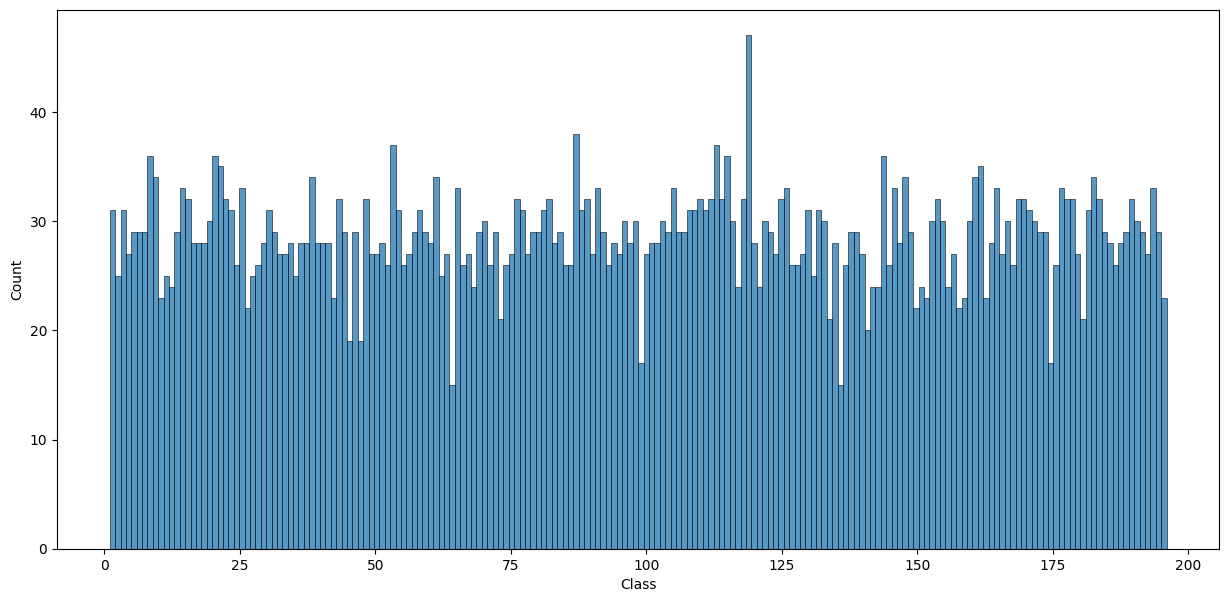

In [ ]:
# гистограмма обучающей выборки
fig, ax = plt.subplots(figsize=(15,7))
sns.histplot(y_train,bins=196)

# Аугментация

In [ ]:
train_transform = transforms.Compose([
          transforms.Resize((224,224)),
          transforms.RandomHorizontalFlip(),
          transforms.RandomRotation((-30,30)),
          transforms.RandomResizedCrop(200),
          transforms.ColorJitter(
            brightness=0.5,
            contrast=0.3,
            hue=0.2),
          transforms.RandomAdjustSharpness(sharpness_factor=2),
          transforms.RandomEqualize(),
          transforms.ToTensor(),
          transforms.Normalize(mean=(0.4707, 0.4602, 0.4550), std=(0.2638, 0.2629, 0.2678)),
        ])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4707, 0.4602, 0.4550), std=(0.2638, 0.2629, 0.2678)),
  ])

In [ ]:
input_folder="/content/dataset"
batch_size=64

trainset = torchvision.datasets.ImageFolder(os.path.join(input_folder, "train"), transform=train_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory = True)

testset = torchvision.datasets.ImageFolder(os.path.join(input_folder, "test"), transform=test_transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory = True)

In [ ]:
classes = []
for i in range(1,197):
  classes.append(str(i))
classes.sort()

def image_shower(images, labels, n=4):
    plt.figure(figsize=(12, 12))
    for i, image in enumerate(images[:n]):
        plt.subplot(n, n, i + 1)
        image = image/ 2 + 0.5
        plt.imshow(image.numpy().transpose((1, 2, 0)).squeeze())
    print("Real Labels: ", ' '.join('%5s' % classes[label] for label in labels[:n]))

Real Labels:     77   157    42    96


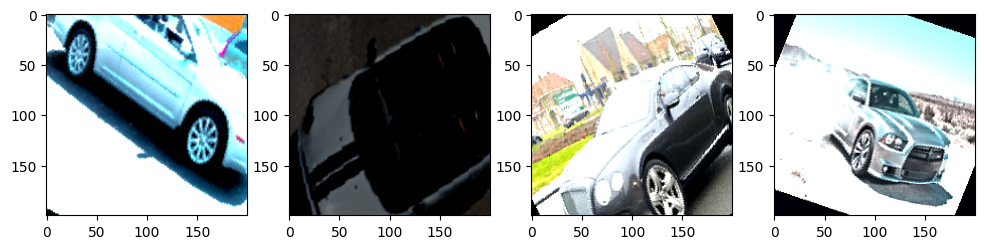

In [ ]:
images, labels = next(iter(train_loader))
image_shower(images, labels)

# Модель

In [ ]:
model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)

model.fc = nn.Sequential(
    nn.Linear(2048,1024, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(1024, 512, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(512, 196, bias=True)
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 66.2MB/s]


In [ ]:
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
summary(model,(3,224,224),batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 122, 122]           9,408
       BatchNorm2d-2         [64, 64, 122, 122]             128
              ReLU-3         [64, 64, 122, 122]               0
         MaxPool2d-4           [64, 64, 61, 61]               0
            Conv2d-5           [64, 64, 61, 61]           4,096
       BatchNorm2d-6           [64, 64, 61, 61]             128
              ReLU-7           [64, 64, 61, 61]               0
            Conv2d-8           [64, 64, 61, 61]          36,864
       BatchNorm2d-9           [64, 64, 61, 61]             128
             ReLU-10           [64, 64, 61, 61]               0
           Conv2d-11          [64, 256, 61, 61]          16,384
      BatchNorm2d-12          [64, 256, 61, 61]             512
           Conv2d-13          [64, 256, 61, 61]          16,384
      BatchNorm2d-14          [64, 256,

# Обучение модели

In [ ]:
EPOCHES = 20
leaning_rate = 0.01

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=leaning_rate, momentum=0.9)

lrscheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [ ]:
loss_list = []
test_acc_list = []

model.train()
for epoch in range(EPOCHES):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        
        outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f'Epoch: {epoch+1}, loss: {(running_loss/len(train_loader)):.3f}')
    loss_list.append(running_loss/len(train_loader))
    model.eval()

    # проверка точности на тестовой выборке
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print(f'val accuracy: {test_acc:.3f} %')

    test_acc_list.append(test_acc)
    
    model.train()
    lrscheduler.step(test_acc)
print('Finished Training')


Epoch: 1, loss: 5.279
val accuracy: 0.857 %
Epoch: 2, loss: 5.274
val accuracy: 0.786 %
Epoch: 3, loss: 5.267
val accuracy: 0.786 %
Epoch: 4, loss: 5.244
val accuracy: 0.786 %
Epoch: 5, loss: 5.118
val accuracy: 2.143 %
Epoch: 6, loss: 4.927
val accuracy: 3.714 %
Epoch: 7, loss: 4.678
val accuracy: 4.500 %
Epoch: 8, loss: 4.358
val accuracy: 10.786 %
Epoch: 9, loss: 3.986
val accuracy: 15.429 %
Epoch: 10, loss: 3.687
val accuracy: 18.071 %
Epoch: 11, loss: 3.427
val accuracy: 22.786 %
Epoch: 12, loss: 3.149
val accuracy: 28.857 %
Epoch: 13, loss: 2.946
val accuracy: 32.214 %
Epoch: 14, loss: 2.680
val accuracy: 36.500 %
Epoch: 15, loss: 2.515
val accuracy: 40.071 %
Epoch: 16, loss: 2.179
val accuracy: 59.214 %
Epoch: 17, loss: 2.026
val accuracy: 61.143 %
Epoch: 18, loss: 1.939
val accuracy: 65.429 %
Epoch: 19, loss: 1.914
val accuracy: 66.357 %
Epoch: 20, loss: 1.814
val accuracy: 66.643 %
Finished Training


# График ошибки от количества эпох

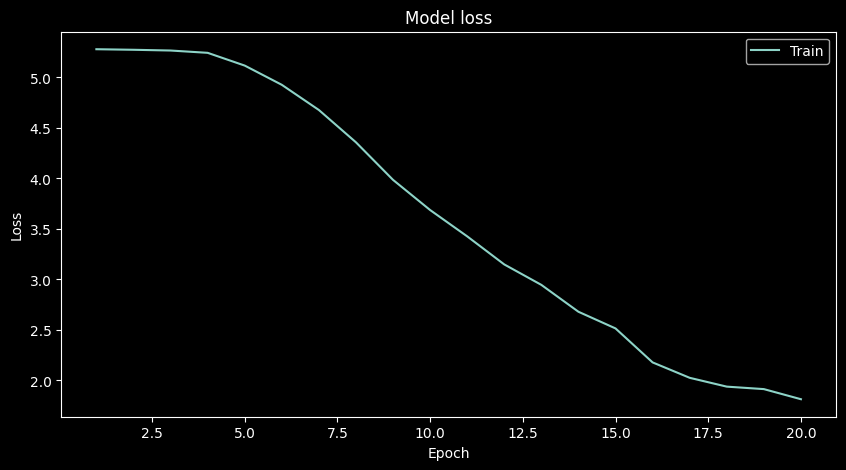

In [ ]:
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(list(range(1, EPOCHES+1)),loss_list)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

# График точности от количества эпох

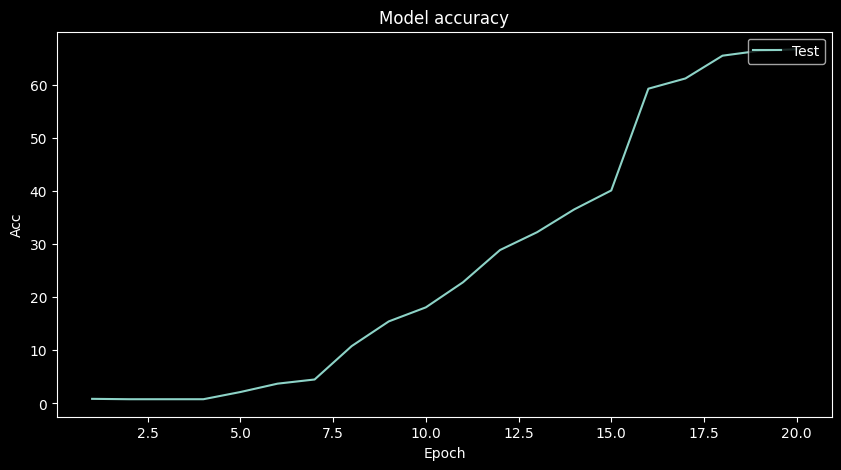

In [ ]:
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(list(range(1, EPOCHES+1)),test_acc_list)
plt.title('Model accuracy')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Test'], loc='upper right')
plt.show()

# Сохранение модели

In [ ]:
model_scripted = torch.jit.script(model)
model_scripted.save('/content/drive/MyDrive/model2.pt')